In [48]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import clear_output
from tqdm.auto import tqdm

from src.solvers import DensitySolver
from src.task import Environment
from src.utils import get_data
from src.tools import get_losses

DATA_ROOT = '../data'
TERMINAL_DATA_PATH = os.path.join(DATA_ROOT, 'terminal_data_hackathon v4.xlsx')
TIMES_DATA_PATH = os.path.join(DATA_ROOT, 'times v4.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


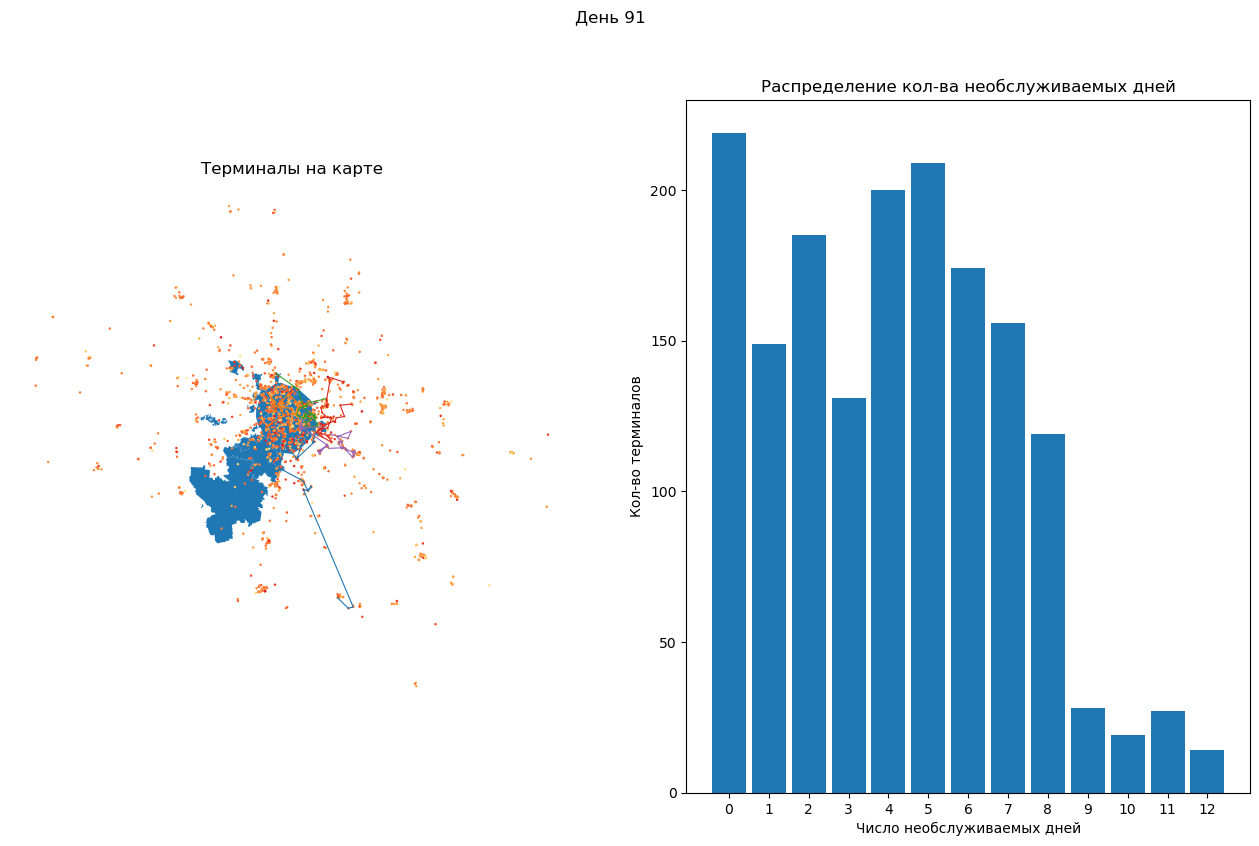

In [114]:
def visualize(title: str):
    """ Визуализация маршрутов + гистограмма прошедшего кол-ва дней для терминалов """
    fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
    moscow.plot(ax=ax[0])
    color_vals = terminals['remains 91']  # np.median(terms[columns[2:]].values, axis=1).clip(1e-6)
    ax[0].scatter(terminals['longitude'], terminals['latitude'], s=0.6, c=color_vals,
                  norm=colors.LogNorm(vmin=color_vals.min(), vmax=color_vals.max()), cmap='YlOrRd')

    for route in routes:
        ax[0].plot(terminals['longitude'].loc[route], terminals['latitude'].loc[route], linewidth=0.8)

    ax[0].axis('off')
    ax[0].set_title('Терминалы на карте')

    n_bins = solver.days_after_service.max() + 1
    n, bins, patches = ax[1].hist(solver.days_after_service, bins=n_bins, rwidth=0.85, align='mid')
    ax[1].set_title('Распределение кол-ва необслуживаемых дней')
    ax[1].set_xlabel('Число необслуживаемых дней')
    ax[1].set_ylabel('Кол-во терминалов')
    ticks = [(2 * patch.get_x() + patch.get_width()) / 2 for patch in patches]
    ticklabels = [i for i in range(n_bins)]
    ax[1].set_xticks(ticks, ticklabels)

    plt.suptitle(title)
    plt.show()


terminals_count = []
moscow = gpd.read_file("ao-shape.zip")
terminals, time_matrix = get_data(DATA_ROOT)
business_logic = Environment()

total_losses = []
solver = DensitySolver(terminals['start_value'].values, time_matrix, business_logic, n_trucks=5)
for day in range(91):
    routes = solver.get_routes()
    clear_output()
    terminals_count.append(sum([len(route) for route in routes]))
    visualize(f'День {day + 1}')
    solver.update(terminals[f'day {day + 1}'])